In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initial Analytics

In [2]:
data = pd.read_excel('/kaggle/input/data-1/data1.xlsx')
data

,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT
0,2023-04-03,2023-04-04,2023-04-04,2
1,2023-04-03,2023-04-04,2023-04-10,1
2,2023-04-03,2023-04-05,2023-04-07,1
3,2023-04-03,2023-04-06,2023-04-06,1
4,2023-04-03,2023-04-11,2023-04-15,1
...,...,...,...,...
3312,2023-06-14,2023-06-15,NaT,107
3313,2023-06-14,NaT,NaT,319
3314,2023-06-15,2023-06-15,2023-06-15,11
3315,2023-06-15,2023-06-15,NaT,37


In [3]:
# we will create the copy one for data analysis and another for prediction
df = data.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   APPLICATION_DATE  3317 non-null   datetime64[ns]
 1   AGREEMENT_DATE    3243 non-null   datetime64[ns]
 2   UTILIZATION_DATE  2799 non-null   datetime64[ns]
 3   CNT               3317 non-null   int64         
dtypes: datetime64[ns](3), int64(1)
memory usage: 103.8 KB


In [5]:
data.isnull().mean()

APPLICATION_DATE    0.000000
AGREEMENT_DATE      0.022309
UTILIZATION_DATE    0.156165
CNT                 0.000000
dtype: float64

In [6]:
data['APPLICATION_DATE'] = pd.to_datetime(data['APPLICATION_DATE'])
data['AGREEMENT_DATE'] = pd.to_datetime(data['AGREEMENT_DATE'])
data['UTILIZATION_DATE'] = pd.to_datetime(data['UTILIZATION_DATE'])

# Зависимость количества подписанных договоров и использованных карт
signed = data.groupby('AGREEMENT_DATE')['CNT'].sum().reset_index()
used = data.groupby('UTILIZATION_DATE')['CNT'].sum().reset_index()

# Подписанные договоры
fig1 = px.line(signed, x='AGREEMENT_DATE', y='CNT', title='Number of Signed Agreements Over Time',
               labels={'CNT': 'Number of Signed Agreements'})
fig1.update_traces(line=dict(color='red'))
fig1.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    autosize=False,
    width=600,
    height=400
)

# Использованные карты
fig2 = px.line(used, x='UTILIZATION_DATE', y='CNT', title='Number of Card Uses Over Time',
               labels={'CNT': 'Number of Card Uses'})
fig2.update_traces(line=dict(color='red'))
fig2.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    autosize=False,
    width=600,
    height=400
)

# Группировка по тому, использовали ли клиенты карты
signed_used = data[data['UTILIZATION_DATE'].notna()].groupby('AGREEMENT_DATE')['CNT'].sum().reset_index()
signed_not_used = data[data['UTILIZATION_DATE'].isna()].groupby('AGREEMENT_DATE')['CNT'].sum().reset_index()

# Подписанные договоры, которые привели к использованию карт
fig3 = px.line(signed_used, x='AGREEMENT_DATE', y='CNT', title='Signed Agreements Leading to Card Use',
               labels={'CNT': 'Number of Cards Used'})
fig3.update_traces(line=dict(color='red'))
fig3.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    autosize=False,
    width=600,
    height=400
)

# Подписанные договоры, которые не привели к использованию карт
fig4 = px.line(signed_not_used, x='AGREEMENT_DATE', y='CNT', title='Signed Agreements with No Card Use',
               labels={'CNT': 'Number of Cards Not Used'})
fig4.update_traces(line=dict(color='red'))
fig4.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    autosize=False,
    width=600,
    height=400
)


fig1.show()
fig2.show()
fig3.show()
fig4.show()


In [7]:
# 'Utilized' column
data['Utilized'] = data['UTILIZATION_DATE'].notna().astype(int)

signed_agreements_with_use = data[data['Utilized'] == 1]
signed_agreements_no_use = data[data['Utilized'] == 0]

# detailed statistics
def calculate_statistics(df, date_column1, date_column2):
    df = df.dropna(subset=[date_column1, date_column2])
    time_diff = (df[date_column2] - df[date_column1]).dt.days

    stats = {
        'Total Records': df.shape[0],
        'Min': time_diff.min(),
        'Max': time_diff.max(),
        'Mean': time_diff.mean(),
        'Median': time_diff.median(),
        'Std Dev': time_diff.std()
    }
    return stats

# statistics for signed agreements leading to card use
stats_with_use = {
    'Total Records': signed_agreements_with_use.shape[0],
    'Average Time from Application to Agreement (days)': (signed_agreements_with_use['AGREEMENT_DATE'] - signed_agreements_with_use['APPLICATION_DATE']).dt.days.mean(),
    'Median Time from Application to Agreement (days)': (signed_agreements_with_use['AGREEMENT_DATE'] - signed_agreements_with_use['APPLICATION_DATE']).dt.days.median(),
    'Average Time from Agreement to Utilization (days)': (signed_agreements_with_use['UTILIZATION_DATE'] - signed_agreements_with_use['AGREEMENT_DATE']).dt.days.mean(),
    'Median Time from Agreement to Utilization (days)': (signed_agreements_with_use['UTILIZATION_DATE'] - signed_agreements_with_use['AGREEMENT_DATE']).dt.days.median(),
    'Min Time from Agreement to Utilization (days)': (signed_agreements_with_use['UTILIZATION_DATE'] - signed_agreements_with_use['AGREEMENT_DATE']).dt.days.min(),
    'Max Time from Agreement to Utilization (days)': (signed_agreements_with_use['UTILIZATION_DATE'] - signed_agreements_with_use['AGREEMENT_DATE']).dt.days.max(),
    'Std Dev Time from Agreement to Utilization (days)': (signed_agreements_with_use['UTILIZATION_DATE'] - signed_agreements_with_use['AGREEMENT_DATE']).dt.days.std()
}

# statistics for signed agreements with no card use
stats_no_use = {
    'Total Records': signed_agreements_no_use.shape[0],
    'Average Time from Application to Agreement (days)': (signed_agreements_no_use['AGREEMENT_DATE'] - signed_agreements_no_use['APPLICATION_DATE']).dt.days.mean(),
    'Median Time from Application to Agreement (days)': (signed_agreements_no_use['AGREEMENT_DATE'] - signed_agreements_no_use['APPLICATION_DATE']).dt.days.median(),
    'Min Time from Application to Agreement (days)': (signed_agreements_no_use['AGREEMENT_DATE'] - signed_agreements_no_use['APPLICATION_DATE']).dt.days.min(),
    'Max Time from Application to Agreement (days)': (signed_agreements_no_use['AGREEMENT_DATE'] - signed_agreements_no_use['APPLICATION_DATE']).dt.days.max(),
    'Std Dev Time from Application to Agreement (days)': (signed_agreements_no_use['AGREEMENT_DATE'] - signed_agreements_no_use['APPLICATION_DATE']).dt.days.std(),
    'Percentage of Agreements with No Card Use': signed_agreements_no_use.shape[0] / data.shape[0] * 100
}

print("Statistics for Signed Agreements Leading to Card Use:")
for key, value in stats_with_use.items():
    print(f"{key}: {value}")

print("\nStatistics for Signed Agreements with No Card Use:")
for key, value in stats_no_use.items():
    print(f"{key}: {value}")


Statistics for Signed Agreements Leading to Card Use:
Total Records: 2799
Average Time from Application to Agreement (days): 7.48302965344766
Median Time from Application to Agreement (days): 5.0
Average Time from Agreement to Utilization (days): 4.276170060735977
Median Time from Agreement to Utilization (days): 2.0
Min Time from Agreement to Utilization (days): 0
Max Time from Agreement to Utilization (days): 61
Std Dev Time from Agreement to Utilization (days): 6.0703971388645614

Statistics for Signed Agreements with No Card Use:
Total Records: 518
Average Time from Application to Agreement (days): 9.495495495495495
Median Time from Application to Agreement (days): 6.0
Min Time from Application to Agreement (days): 0.0
Max Time from Application to Agreement (days): 60.0
Std Dev Time from Application to Agreement (days): 9.665627703162489
Percentage of Agreements with No Card Use: 15.616520952668072


In [8]:
data

,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT,Utilized
0,2023-04-03,2023-04-04,2023-04-04,2,1
1,2023-04-03,2023-04-04,2023-04-10,1,1
2,2023-04-03,2023-04-05,2023-04-07,1,1
3,2023-04-03,2023-04-06,2023-04-06,1,1
4,2023-04-03,2023-04-11,2023-04-15,1,1
...,...,...,...,...,...
3312,2023-06-14,2023-06-15,NaT,107,0
3313,2023-06-14,NaT,NaT,319,0
3314,2023-06-15,2023-06-15,2023-06-15,11,1
3315,2023-06-15,2023-06-15,NaT,37,0


In [9]:
def create_features(data):
    #  date differences
    data['DIFFERENCE_AA'] = (data['AGREEMENT_DATE'] - data['APPLICATION_DATE']).dt.days
    data['DIFFERENCE_AU'] = (data['UTILIZATION_DATE'] - data['AGREEMENT_DATE']).dt.days
    data['days_between_application_and_utilization'] = (data['UTILIZATION_DATE'] - data['APPLICATION_DATE']).dt.days

    # Binary features based on date comparisons
    data['Same_Day_Agreement_Utilization'] = (data['AGREEMENT_DATE'] == data['UTILIZATION_DATE']).astype(int)
    data['Same_Day_Application_Agreement'] = (data['APPLICATION_DATE'] == data['AGREEMENT_DATE']).astype(int)
    data['Missing_Agreement_Date'] = data['AGREEMENT_DATE'].isna().astype(int)

    # Categorical features based on dates
    data['application_day_of_week'] = data['APPLICATION_DATE'].dt.dayofweek
    data['application_month'] = data['APPLICATION_DATE'].dt.month
    data['agreement_day_of_week'] = data['AGREEMENT_DATE'].dt.dayofweek
    data['Agreement_Reached'] = data['AGREEMENT_DATE'].notna().astype(int)

    # Binary features indicating whether the date falls on a weekend
    data['is_application_on_weekend'] = data['application_day_of_week'].isin([5, 6]).astype(int)
    data['is_agreement_on_weekend'] = data['agreement_day_of_week'].isin([5, 6]).astype(int)

    # Binary feature indicating if the card was utilized
    data['if_utilised'] = np.where(data['UTILIZATION_DATE'].isna(), 0, 1)
    
    return data


In [10]:
data = create_features(data)
data_new =data.copy()
data_new.drop(columns=['APPLICATION_DATE', 'AGREEMENT_DATE', 'UTILIZATION_DATE','CNT'], inplace = True )

In [11]:
def find_highly_correlated_features(data, threshold=0.5):

    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))
    highly_correlated_pairs = [(column, index) for column in upper.columns 
                               for index in upper.index 
                               if upper.loc[index, column] > threshold]
    highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2'])
    
    return highly_correlated_df

data = create_features(data)
highly_correlated_features = find_highly_correlated_features(data, threshold=0.5)
print(highly_correlated_features)


                                   Feature 1                Feature 2
0                                        CNT           AGREEMENT_DATE
1                                   Utilized         UTILIZATION_DATE
2   days_between_application_and_utilization            DIFFERENCE_AA
3   days_between_application_and_utilization            DIFFERENCE_AU
4                     Missing_Agreement_Date           AGREEMENT_DATE
5                     Missing_Agreement_Date                      CNT
6                          application_month         APPLICATION_DATE
7                          Agreement_Reached           AGREEMENT_DATE
8                          Agreement_Reached                      CNT
9                          Agreement_Reached   Missing_Agreement_Date
10                 is_application_on_weekend  application_day_of_week
11                   is_agreement_on_weekend    agreement_day_of_week
12                               if_utilised         UTILIZATION_DATE
13                  

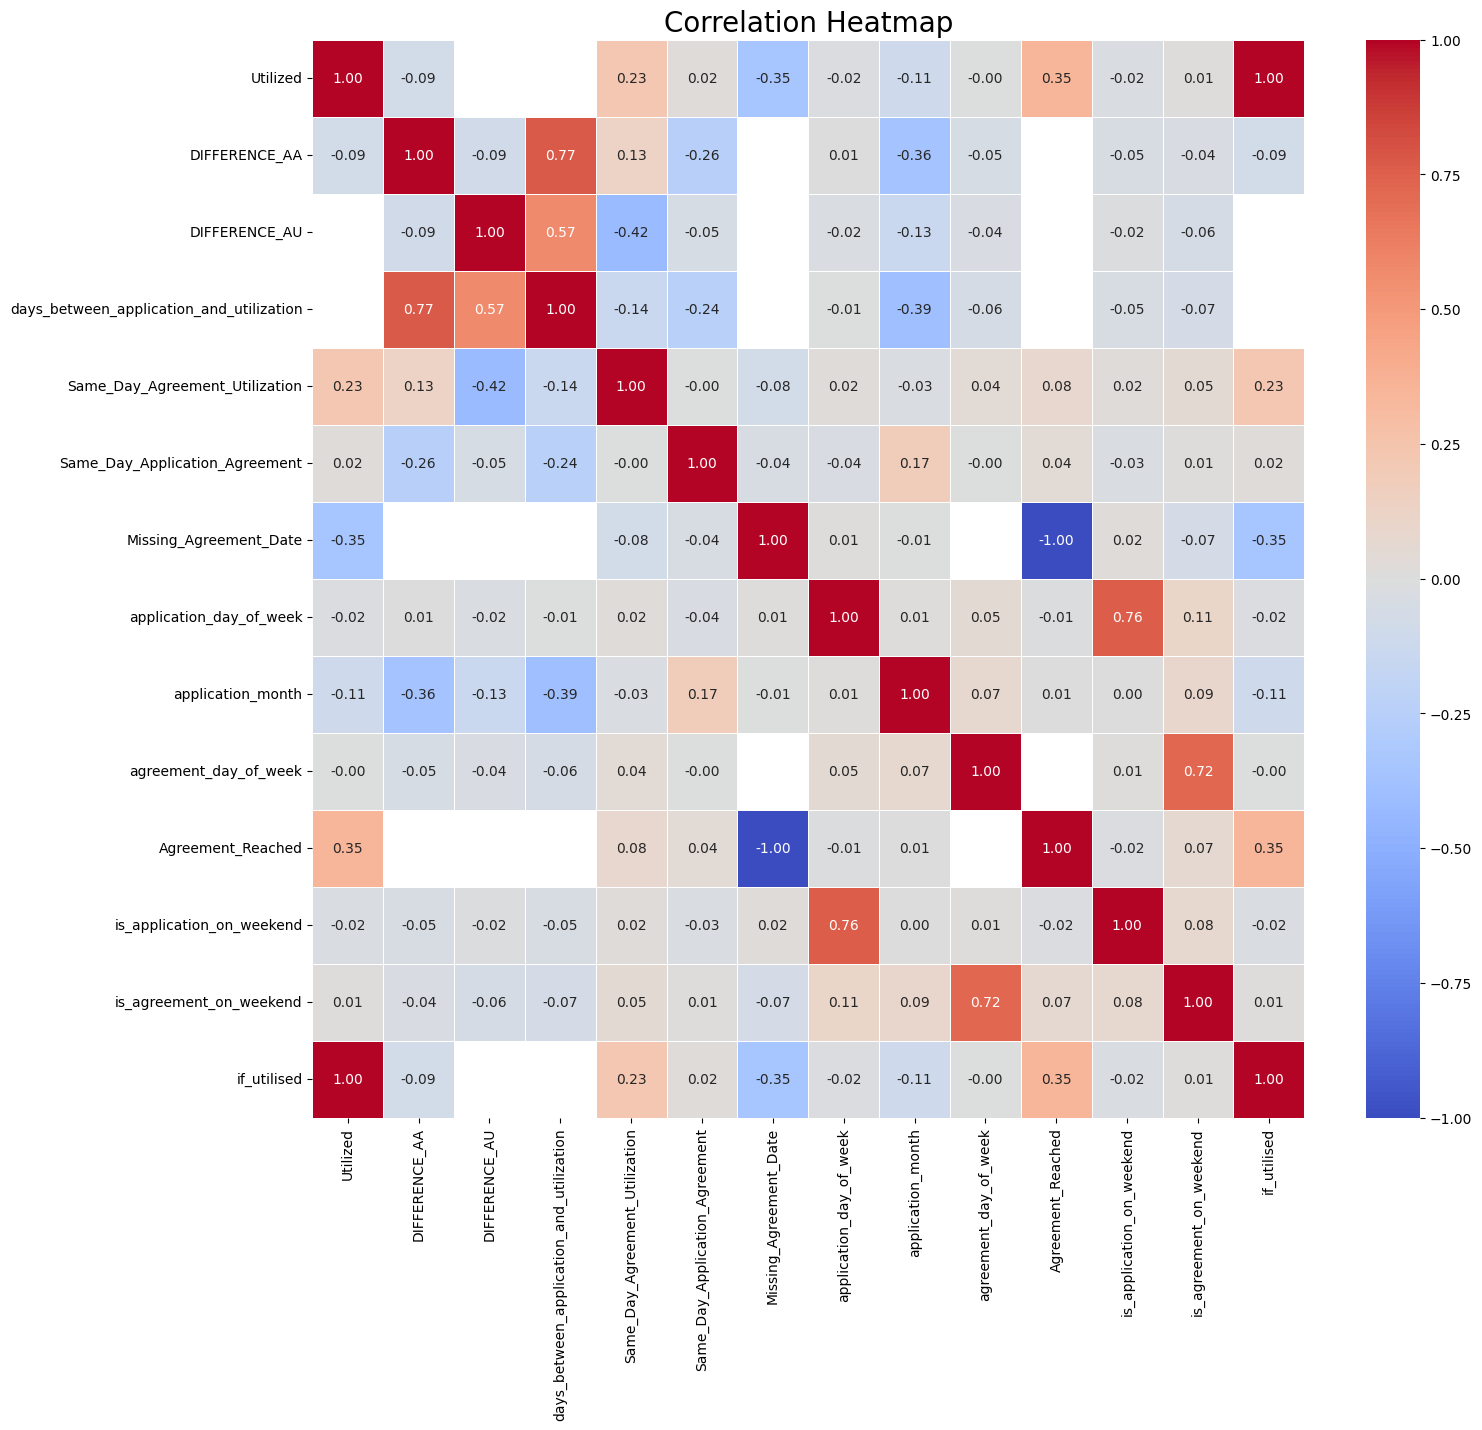

In [12]:
plt.figure(figsize=(16, 14))  
sns.heatmap(data_new.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', size=20)
plt.show()

In [13]:
def calculate_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

outliers_aa = calculate_outliers(data['DIFFERENCE_AA'])
outliers_au = calculate_outliers(data['DIFFERENCE_AU'])

# Count the number of outliers
num_outliers_aa = outliers_aa.count()
num_outliers_au = outliers_au.count()

print(f"Number of outliers in 'DIFFERENCE_AA': {num_outliers_aa}")
print(f"Number of outliers in 'DIFFERENCE_AU': {num_outliers_au}")


Number of outliers in 'DIFFERENCE_AA': 226
Number of outliers in 'DIFFERENCE_AU': 165


In [14]:
# a color column to mark outliers
data['color_AA'] = np.where(data['DIFFERENCE_AA'].isin(outliers_aa), 'red', 'blue')
data['color_AU'] = np.where(data['DIFFERENCE_AU'].isin(outliers_au), 'red', 'blue')

#  DIFF_AA with outliers in red
fig1 = px.scatter(data, x='APPLICATION_DATE', y='DIFFERENCE_AA',
                  color='color_AA',
                  title=f'Difference AA with Outliers Highlighted ({num_outliers_aa} outliers)',
                  color_discrete_map={'red': 'red', 'blue': 'blue'})
fig1.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    autosize=False,
    width=800,
    height=400
)

# DIFF_AU with outliers in red
fig2 = px.scatter(data, x='AGREEMENT_DATE', y='DIFFERENCE_AU',
                  color='color_AU',
                  title=f'Difference AU with Outliers Highlighted ({num_outliers_au} outliers)',
                  color_discrete_map={'red': 'red', 'blue': 'blue'})
fig2.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='LightGrey', gridwidth=1),
    autosize=False,
    width=800,
    height=400
)
fig1.show()
fig2.show()


/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



#Segmantation

In [15]:
# Segmenting the data into two groups
utilized_data = data[data['UTILIZATION_DATE'].notna()]
not_utilized_data = data[data['UTILIZATION_DATE'].isna()]

# Statistics for each group
print("Statistics for Utilized Data:")
print(utilized_data.describe())

print("\nStatistics for Not Utilized Data:")
print(not_utilized_data.describe())


Statistics for Utilized Data:
                    APPLICATION_DATE                 AGREEMENT_DATE  \
count                           2799                           2799   
mean   2023-05-10 15:06:29.710610944  2023-05-18 02:42:03.472668928   
min              2023-04-03 00:00:00            2023-04-04 00:00:00   
25%              2023-04-24 00:00:00            2023-05-08 00:00:00   
50%              2023-05-12 00:00:00            2023-05-20 00:00:00   
75%              2023-05-25 00:00:00            2023-05-31 00:00:00   
max              2023-06-15 00:00:00            2023-06-15 00:00:00   
std                              NaN                            NaN   

                    UTILIZATION_DATE          CNT  Utilized  DIFFERENCE_AA  \
count                           2799  2799.000000    2799.0    2799.000000   
mean   2023-05-22 09:19:44.565916416     2.076099       1.0       7.483030   
min              2023-04-04 00:00:00     1.000000       1.0       0.000000   
25%              2

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



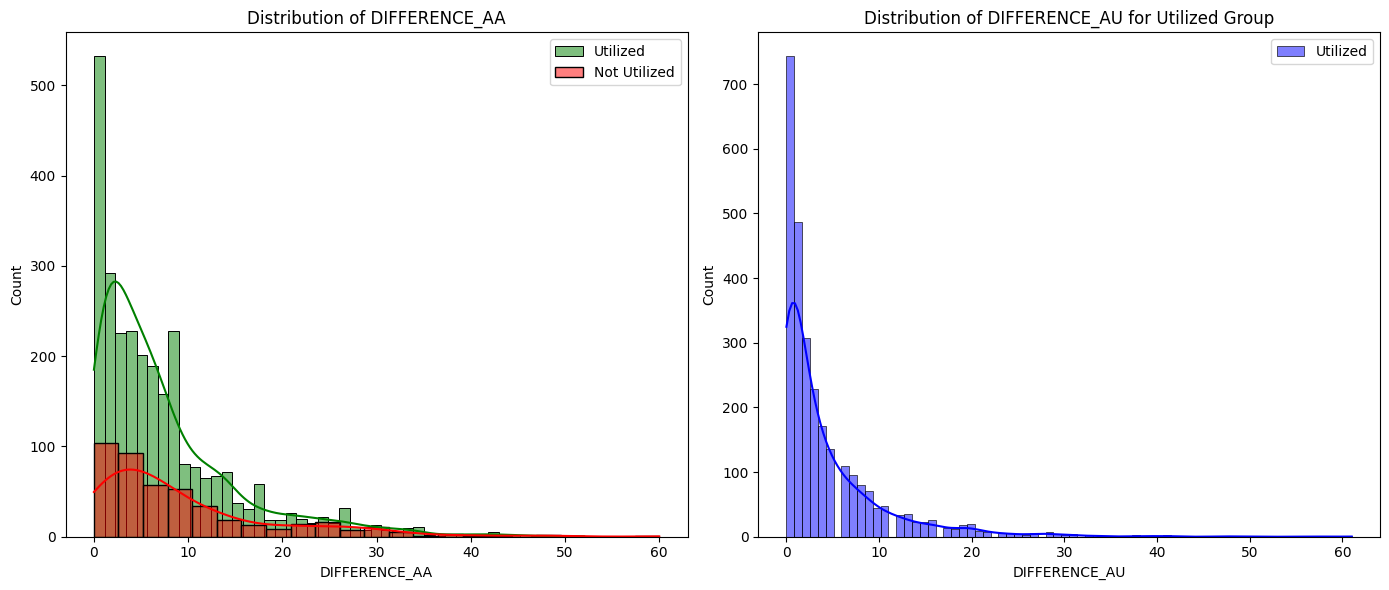

In [16]:
# distribution of DIFFERENCE_AA for both groups
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(utilized_data['DIFFERENCE_AA'], kde=True, color='green', label='Utilized')
sns.histplot(not_utilized_data['DIFFERENCE_AA'], kde=True, color='red', label='Not Utilized')
plt.title('Distribution of DIFFERENCE_AA')
plt.legend()

# distribution of DIFFERENCE_AU for utilized group only
plt.subplot(1, 2, 2)
sns.histplot(utilized_data['DIFFERENCE_AU'], kde=True, color='blue', label='Utilized')
plt.title('Distribution of DIFFERENCE_AU for Utilized Group')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
import plotly.figure_factory as ff

# Histogram and KDE for DIFFERENCE_AA (Red)
fig1 = ff.create_distplot([data['DIFFERENCE_AA'].dropna()], ['Difference AA'], show_hist=True, show_rug=False, colors=['red'])
fig1.update_layout(title='Distribution of Difference AA (Red Theme)', plot_bgcolor='rgba(0, 0, 0, 0)')
fig1.show()

# Histogram and KDE for DIFFERENCE_AU (Red)
fig2 = ff.create_distplot([data['DIFFERENCE_AU'].dropna()], ['Difference AU'], show_hist=True, show_rug=False, colors=['red'])
fig2.update_layout(title='Distribution of Difference AU (Red Theme)', plot_bgcolor='rgba(0, 0, 0, 0)')
fig2.show()


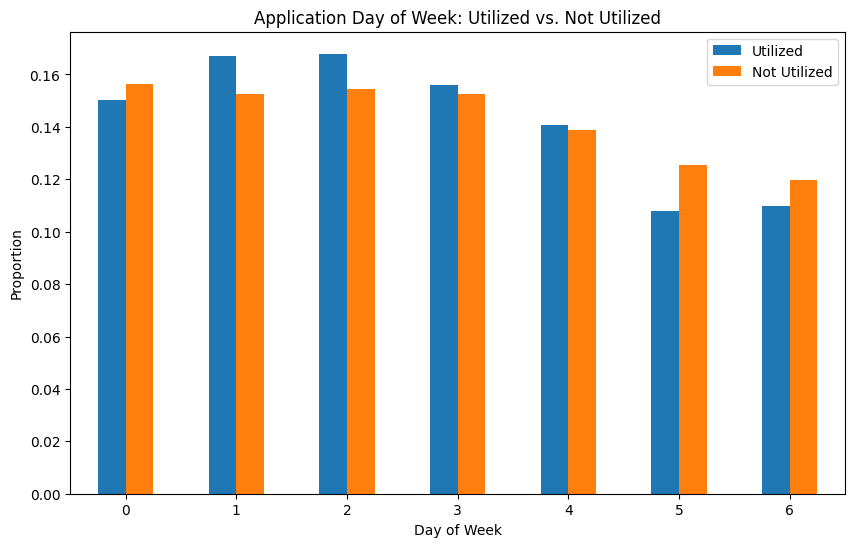

In [18]:
# Compare categorical features between the two groups

# Day of Week Analysis
utilized_day_of_week = utilized_data['application_day_of_week'].value_counts(normalize=True)
not_utilized_day_of_week = not_utilized_data['application_day_of_week'].value_counts(normalize=True)

day_of_week_df = pd.DataFrame({
    'Utilized': utilized_day_of_week,
    'Not Utilized': not_utilized_day_of_week
})

day_of_week_df.plot(kind='bar', figsize=(10, 6))
plt.title('Application Day of Week: Utilized vs. Not Utilized')
plt.xlabel('Day of Week')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()


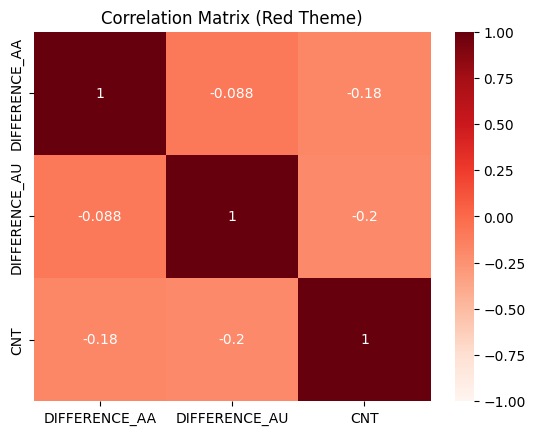

In [19]:
# correlation matrix
corr_matrix = data[['DIFFERENCE_AA', 'DIFFERENCE_AU', 'CNT']].corr()

# Heatmap with red color palette
sns.heatmap(corr_matrix, annot=True, cmap='Reds', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Red Theme)')
plt.show()

In [20]:
# the key differences between the two groups

utilized_summary = utilized_data[['DIFFERENCE_AA', 'DIFFERENCE_AU']].describe()
not_utilized_summary = not_utilized_data[['DIFFERENCE_AA']].describe()

print("Summary Statistics for Utilized Data:")
print(utilized_summary)

print("\nSummary Statistics for Not Utilized Data:")
print(not_utilized_summary)

Summary Statistics for Utilized Data:
       DIFFERENCE_AA  DIFFERENCE_AU
count    2799.000000    2799.000000
mean        7.483030       4.276170
std         7.749079       6.070397
min         0.000000       0.000000
25%         2.000000       0.000000
50%         5.000000       2.000000
75%        10.000000       6.000000
max        52.000000      61.000000

Summary Statistics for Not Utilized Data:
       DIFFERENCE_AA
count     444.000000
mean        9.495495
std         9.665628
min         0.000000
25%         3.000000
50%         6.000000
75%        13.000000
max        60.000000


In [21]:
data.fillna(0, inplace=True)
data

/tmp/ipykernel_19/1995161715.py:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.



,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT,Utilized,DIFFERENCE_AA,DIFFERENCE_AU,days_between_application_and_utilization,Same_Day_Agreement_Utilization,Same_Day_Application_Agreement,Missing_Agreement_Date,application_day_of_week,application_month,agreement_day_of_week,Agreement_Reached,is_application_on_weekend,is_agreement_on_weekend,if_utilised,color_AA,color_AU
0,2023-04-03,2023-04-04 00:00:00,2023-04-04 00:00:00,2,1,1.0,0.0,1.0,1,0,0,0,4,1.0,1,0,0,1,blue,blue
1,2023-04-03,2023-04-04 00:00:00,2023-04-10 00:00:00,1,1,1.0,6.0,7.0,0,0,0,0,4,1.0,1,0,0,1,blue,blue
2,2023-04-03,2023-04-05 00:00:00,2023-04-07 00:00:00,1,1,2.0,2.0,4.0,0,0,0,0,4,2.0,1,0,0,1,blue,blue
3,2023-04-03,2023-04-06 00:00:00,2023-04-06 00:00:00,1,1,3.0,0.0,3.0,1,0,0,0,4,3.0,1,0,0,1,blue,blue
4,2023-04-03,2023-04-11 00:00:00,2023-04-15 00:00:00,1,1,8.0,4.0,12.0,0,0,0,0,4,1.0,1,0,0,1,blue,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,2023-06-14,2023-06-15 00:00:00,0,107,0,1.0,0.0,0.0,0,0,0,2,6,3.0,1,0,0,0,blue,blue
3313,2023-06-14,0,0,319,0,0.0,0.0,0.0,0,0,1,2,6,0.0,0,0,0,0,blue,blue
3314,2023-06-15,2023-06-15 00:00:00,2023-06-15 00:00:00,11,1,0.0,0.0,0.0,1,1,0,3,6,3.0,1,0,0,1,blue,blue
3315,2023-06-15,2023-06-15 00:00:00,0,37,0,0.0,0.0,0.0,0,1,0,3,6,3.0,1,0,0,0,blue,blue


#Prediction and Further Analytics

#First: To look at problem like on classification task

In [22]:
def create_features(data):
    # Difference columns
    data['DIFFERENCE_AA'] = (data['AGREEMENT_DATE'] - data['APPLICATION_DATE']).dt.days

    # Categorical features based on dates
    data['application_day_of_week'] = data['APPLICATION_DATE'].dt.dayofweek
    data['application_month'] = data['APPLICATION_DATE'].dt.month
    data['agreement_day_of_week'] = data['AGREEMENT_DATE'].dt.dayofweek

    data['days_between_agreement_and_utilization'] = (data['UTILIZATION_DATE'] - data['AGREEMENT_DATE']).dt.days

    # Binary features
    data['is_application_on_weekend'] = data['application_day_of_week'].isin([5, 6]).astype(int)
    data['is_agreement_on_weekend'] = data['agreement_day_of_week'].isin([5, 6]).astype(int)
    data['if_agreed'] = np.where(pd.notna(data['AGREEMENT_DATE']), 1, 0)
    # Seasonal features
    data['if_utilised'] = np.where(data['UTILIZATION_DATE'].isna(), 0, 1)
    data['Row_Index'] = range(1, len(data) + 1)
    return data

In [23]:
df = create_features(df)
columns = ['Row_Index'] + [col for col in df.columns if col != 'Row_Index']
df = df[columns]

In [24]:
# features and target variable
X = df.drop(columns=['if_utilised', 'UTILIZATION_DATE'])  # Features
y = df['if_utilised']  # Target variable
# Extract the Row_Index for later identification
row_index = df['Row_Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2653, 12)
X_test shape: (664, 12)
y_train shape: (2653,)
y_test shape: (664,)


Training Set Distribution: [ 400 2253]
Training Set Proportions: [0.15077271 0.84922729]
Test Set Distribution: [118 546]
Test Set Proportions: [0.17771084 0.82228916]


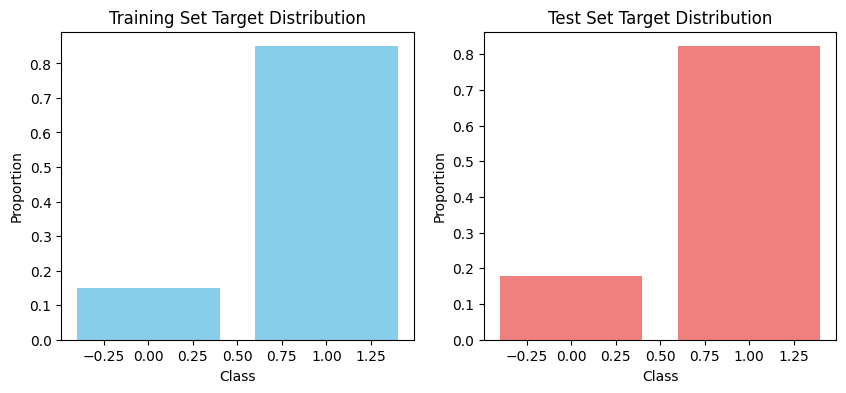

In [25]:
# Calculate the distribution of the target variable in the training set
y_train_distribution = np.bincount(y_train)
y_test_distribution = np.bincount(y_test)

# Calculate proportions
y_train_proportions = y_train_distribution / len(y_train)
y_test_proportions = y_test_distribution / len(y_test)

# Print the results
print("Training Set Distribution:", y_train_distribution)
print("Training Set Proportions:", y_train_proportions)
print("Test Set Distribution:", y_test_distribution)
print("Test Set Proportions:", y_test_proportions)

# Visualize the distribution in the training set
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(y_train_distribution)), y_train_proportions, color='skyblue')
plt.title('Training Set Target Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')

# Visualize the distribution in the test set
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(y_test_distribution)), y_test_proportions, color='lightcoral')
plt.title('Test Set Target Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.show()

The target variable is indeed unbalanced. In both the training and test sets, Class 1 is significantly more prevalent than Class 0. This could lead to biased model predictions, where the model may tend to favor the majority class (Class 1) due to its higher frequency in the data -> we will assign the weights to 0 class

Using the mean to impute missing values is a simpler and often effective method, particularly when the missing data is not too extensive and the data distribution is roughly symmetric.

In [26]:
df.columns

Index(['Row_Index', 'APPLICATION_DATE', 'AGREEMENT_DATE', 'UTILIZATION_DATE',
       'CNT', 'DIFFERENCE_AA', 'application_day_of_week', 'application_month',
       'agreement_day_of_week', 'days_between_agreement_and_utilization',
       'is_application_on_weekend', 'is_agreement_on_weekend', 'if_agreed',
       'if_utilised'],
      dtype='object')

In [27]:
df_new = df[[
       'CNT', 'DIFFERENCE_AA', 'application_day_of_week',
       'application_month', 'agreement_day_of_week',
       'days_between_agreement_and_utilization',
        'if_agreed',
       'if_utilised']]

# Compute the correlation matrix
corr_matrix = df_new.corr()

# Create an interactive heatmap
fig = px.imshow(corr_matrix,
                color_continuous_scale='bluered',  # Use a supported colorscale
                text_auto=True,
                title='Correlation Heatmap')

# Update layout for better readability
fig.update_layout(
    xaxis_title='Features',
    yaxis_title='Features',
    title_font_size=24,
    xaxis_tickangle=-45,
    width=1000,  # Set width of the heatmap
    height=800   # Set height of the heatmap
)

# Show the interactive heatmap
fig.show()



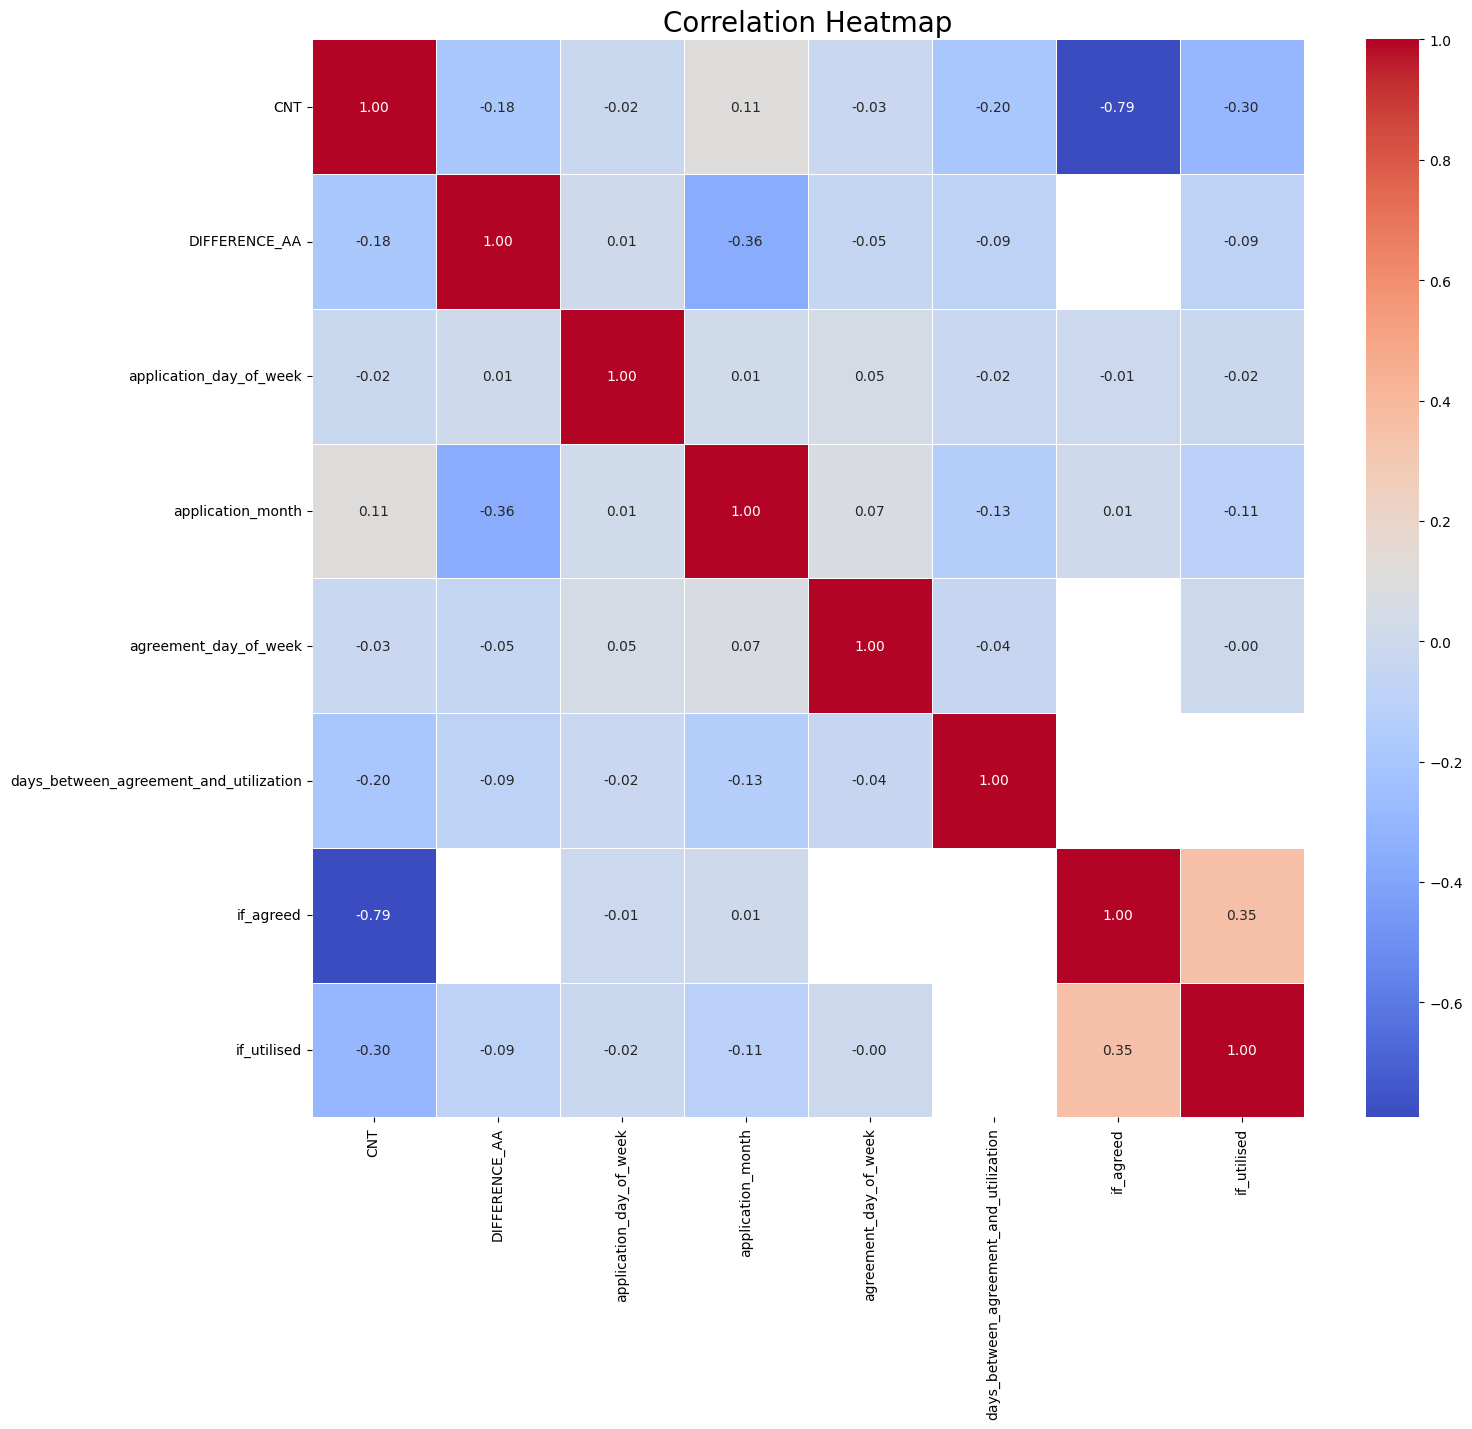

In [28]:
plt.figure(figsize=(16, 14))  # Set the size of the figure
sns.heatmap(df_new.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', size=20)
plt.show()

#Feature Importance